<a href="https://colab.research.google.com/github/prosvirinKir/Deep-Learning-Sckool-term1/blob/main/hw_8_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import clear_output
sns.set(style='darkgrid', font_scale=1.2)
import time
import pylab as pl

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

In [2]:
!pip install -U --no-cache-dir gdown --pre

#64x64
!gdown --id 1RpAjKLktZKIgVQjfpQRDQKDE4L5MsIV4
!unzip -q faces64c.zip && rm faces64c.zip

# 512x512
# !gdown --id 14Y0pv9oex8EmrhCOBXrMrx2OswjzoIsI
# !unzip -q faces512c.zip && rm faces512c.zip

# 256x256
# !gdown --id 1FcJ4d66dic7wF_R4oLYKoDHQKldzxbNU
# !unzip -q faces256c.zip && rm faces256c.zip

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-cp37-none-any.whl size=9046 sha256=aa8b4f4501a86e0ba8ff1b580f2ec681211c01c0cf8a58b9a9d9453a0fb31391
  Stored in directory: /tmp/pip-ephem-wheel-cache-enpkjtye/wheels/ba/fa/c5/12813d7496f34652c43a471e11a780e769889d06e34735c32e
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4
Downloading...
From: https://drive.google.com/uc?id=1RpAjKLktZKIgVQjfpQRDQKDE4L5MsIV4
To: /content/faces64c.zip
22.8MB [00:00, 271MB/s]


In [3]:
# image_size = 512
image_size = 64
# image_size = 256
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
#TODO: build dataloader and transfer it to device/

In [4]:
DATA_DIR = './faces64c/'

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [6]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True) #3143

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

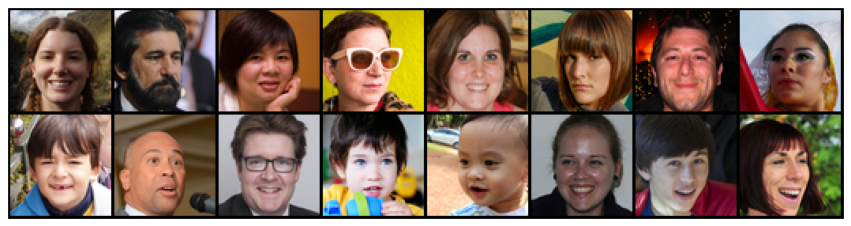

In [9]:
show_batch(train_dl)

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [17]:
generator = to_device(generator, device)

In [18]:
# xb = torch.randn(batch_size, latent_size, 1, 1) 
# fake_images = generator(xb)
# print(fake_images.shape)
# show_images(fake_images)

In [19]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [20]:
fixed_latent = torch.randn(16, latent_size, 1, 1, device=device)

In [21]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [22]:
lr = 0.0001
epochs = 300

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [23]:
# noise coef
alpha = 0.1

In [24]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            # Make some noize
            real_targets += alpha * torch.randn_like(real_targets)

            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            # Make some noize
            fake_targets += alpha * torch.abs(torch.randn_like(fake_targets))

            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch % 50 == 0:
          save_samples(epoch+start_idx, fixed_latent, show=False)

        if epoch % 50 == 0:
          show_images(model['generator'](fixed_latent).cpu().detach())
          clear_output(wait=True)
          display(pl.gcf())
          time.sleep(1.0)
    
    return losses_g, losses_d, real_scores, fake_scores

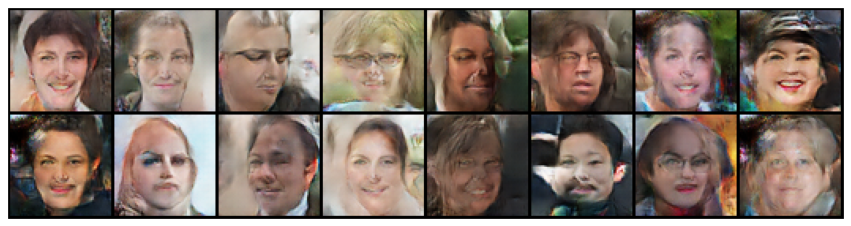


Epoch [252/300], loss_g: 2.9163, loss_d: 0.3455, real_score: 0.9778, fake_score: 0.1005



Epoch [253/300], loss_g: 3.0229, loss_d: 0.3636, real_score: 0.9771, fake_score: 0.1024



Epoch [254/300], loss_g: 2.9398, loss_d: 0.3557, real_score: 0.9780, fake_score: 0.0997



Epoch [255/300], loss_g: 2.9863, loss_d: 0.3587, real_score: 0.9768, fake_score: 0.1022



Epoch [256/300], loss_g: 3.0160, loss_d: 0.3865, real_score: 0.9746, fake_score: 0.1031



Epoch [257/300], loss_g: 2.8466, loss_d: 0.3623, real_score: 0.9785, fake_score: 0.0995



Epoch [258/300], loss_g: 2.9682, loss_d: 0.3639, real_score: 0.9770, fake_score: 0.1027



Epoch [259/300], loss_g: 2.8907, loss_d: 0.3481, real_score: 0.9793, fake_score: 0.1005



Epoch [260/300], loss_g: 2.9173, loss_d: 0.3600, real_score: 0.9765, fake_score: 0.1010



Epoch [261/300], loss_g: 2.9149, loss_d: 0.3459, real_score: 0.9803, fake_score: 0.1025



Epoch [262/300], loss_g: 2.8683, loss_d: 0.3521, real_score: 0.9790, fake_score: 0.1015



Epoch [263/300], loss_g: 2.9039, loss_d: 0.3633, real_score: 0.9772, fake_score: 0.1015



Epoch [264/300], loss_g: 2.9522, loss_d: 0.3676, real_score: 0.9783, fake_score: 0.1004



Epoch [265/300], loss_g: 2.8886, loss_d: 0.3334, real_score: 0.9803, fake_score: 0.1027



Epoch [266/300], loss_g: 2.9271, loss_d: 0.3375, real_score: 0.9808, fake_score: 0.1009



Epoch [267/300], loss_g: 2.9039, loss_d: 0.3450, real_score: 0.9801, fake_score: 0.0996



Epoch [268/300], loss_g: 2.9654, loss_d: 0.3766, real_score: 0.9783, fake_score: 0.0969



Epoch [269/300], loss_g: 2.8602, loss_d: 0.3463, real_score: 0.9792, fake_score: 0.1015



Epoch [270/300], loss_g: 2.9085, loss_d: 0.3474, real_score: 0.9787, fake_score: 0.1034



Epoch [271/300], loss_g: 2.9184, loss_d: 0.3474, real_score: 0.9790, fake_score: 0.0989



Epoch [272/300], loss_g: 2.9169, loss_d: 0.3364, real_score: 0.9813, fake_score: 0.0984



Epoch [273/300], loss_g: 2.9386, loss_d: 0.3324, real_score: 0.9798, fake_score: 0.0990



Epoch [274/300], loss_g: 2.9736, loss_d: 0.3465, real_score: 0.9815, fake_score: 0.1007



Epoch [275/300], loss_g: 2.9402, loss_d: 0.3727, real_score: 0.9773, fake_score: 0.1017



Epoch [276/300], loss_g: 2.9478, loss_d: 0.3576, real_score: 0.9780, fake_score: 0.1010



Epoch [277/300], loss_g: 2.9455, loss_d: 0.3470, real_score: 0.9783, fake_score: 0.1013



Epoch [278/300], loss_g: 2.9039, loss_d: 0.3458, real_score: 0.9789, fake_score: 0.1014



Epoch [279/300], loss_g: 2.9966, loss_d: 0.3558, real_score: 0.9790, fake_score: 0.1015



Epoch [280/300], loss_g: 2.8931, loss_d: 0.3655, real_score: 0.9770, fake_score: 0.0985



Epoch [281/300], loss_g: 2.9357, loss_d: 0.3185, real_score: 0.9825, fake_score: 0.1008



Epoch [282/300], loss_g: 2.8853, loss_d: 0.3531, real_score: 0.9808, fake_score: 0.0968



Epoch [283/300], loss_g: 2.8940, loss_d: 0.3498, real_score: 0.9807, fake_score: 0.0992



Epoch [284/300], loss_g: 2.9563, loss_d: 0.3680, real_score: 0.9780, fake_score: 0.0994



Epoch [285/300], loss_g: 2.8720, loss_d: 0.3503, real_score: 0.9818, fake_score: 0.1005



Epoch [286/300], loss_g: 2.9045, loss_d: 0.3684, real_score: 0.9771, fake_score: 0.1019



Epoch [287/300], loss_g: 2.9029, loss_d: 0.3633, real_score: 0.9767, fake_score: 0.1037



Epoch [288/300], loss_g: 2.9087, loss_d: 0.3821, real_score: 0.9758, fake_score: 0.1000



Epoch [289/300], loss_g: 2.8587, loss_d: 0.3519, real_score: 0.9803, fake_score: 0.1003



Epoch [290/300], loss_g: 2.8617, loss_d: 0.3604, real_score: 0.9786, fake_score: 0.0983



Epoch [291/300], loss_g: 2.9348, loss_d: 0.3377, real_score: 0.9816, fake_score: 0.0999



Epoch [292/300], loss_g: 2.8674, loss_d: 0.3446, real_score: 0.9808, fake_score: 0.1002



Epoch [293/300], loss_g: 2.8705, loss_d: 0.3503, real_score: 0.9823, fake_score: 0.1019



Epoch [294/300], loss_g: 2.9414, loss_d: 0.3477, real_score: 0.9801, fake_score: 0.1004



Epoch [295/300], loss_g: 2.9149, loss_d: 0.3332, real_score: 0.9830, fake_score: 0.0970



Epoch [296/300], loss_g: 2.8834, loss_d: 0.3434, real_score: 0.9798, fake_score: 0.0997



Epoch [297/300], loss_g: 2.8916, loss_d: 0.3380, real_score: 0.9797, fake_score: 0.1013



Epoch [298/300], loss_g: 2.8838, loss_d: 0.3708, real_score: 0.9780, fake_score: 0.1013



Epoch [299/300], loss_g: 2.7932, loss_d: 0.3556, real_score: 0.9798, fake_score: 0.0991



Epoch [300/300], loss_g: 2.8892, loss_d: 0.3583, real_score: 0.9799, fake_score: 0.1016


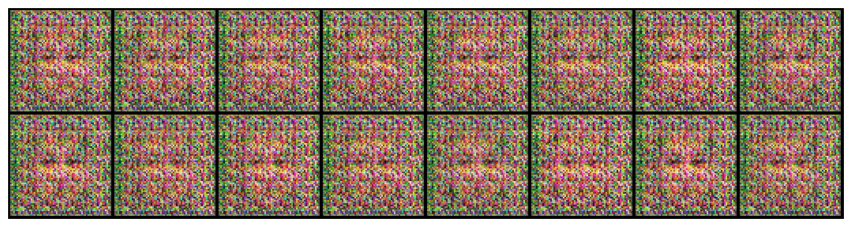

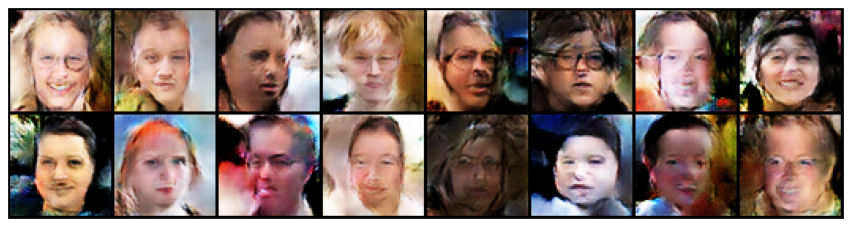

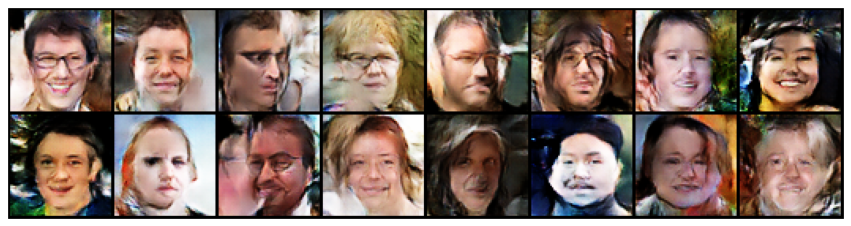

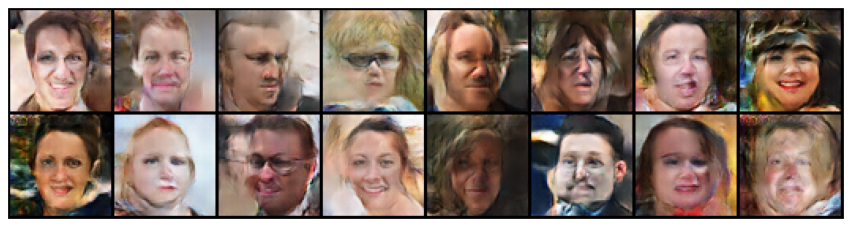

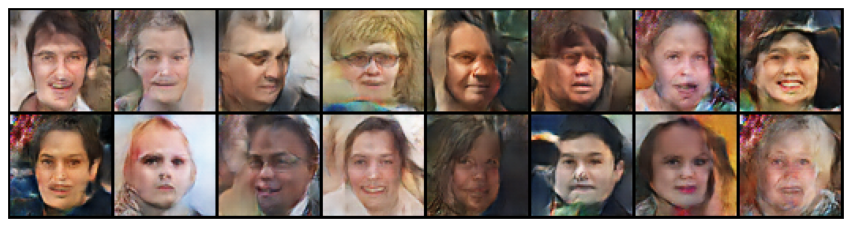

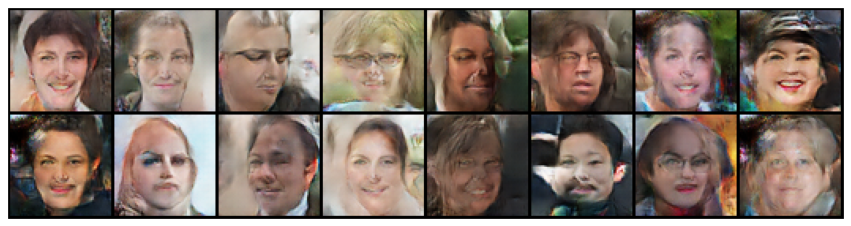

In [25]:
history = fit(model, criterion, epochs=epochs, lr=lr)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [26]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [27]:
def show_generated_images(generated):
  show_images(generated)

In [28]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
generated = model['generator'](fixed_latent).cpu().detach()

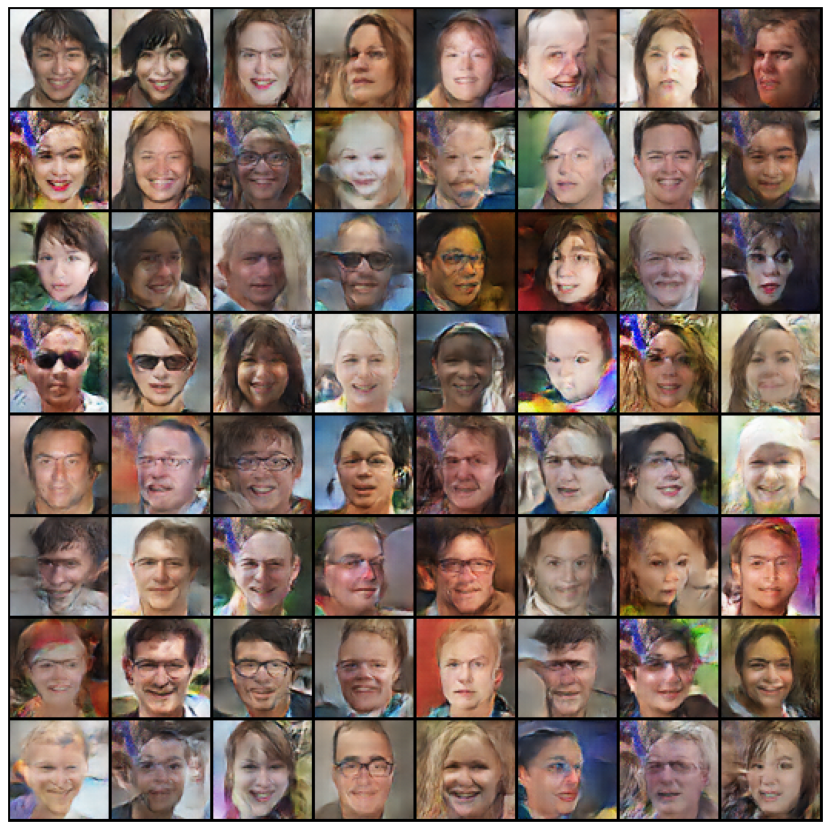

In [29]:
show_generated_images(generated)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [30]:
num_images = 3143
fixed_latent = torch.randn(num_images, latent_size, 1, 1, device=device)
x_fake = model['generator'](fixed_latent).cpu().detach().numpy()
y_fake = np.zeros((num_images, 1))

In [32]:
x_real = np.zeros((num_images, 3, 64, 64))
y_real = np.ones_like(y_fake)

for idx, item in enumerate(train_ds):
    if idx == num_images:
        break
    x_real[idx] = item[0]

In [33]:
# растянем картинку с shape=3x64x64 в один вектор с shape=3*64*64
x_data = np.vstack((x_real, x_fake)).reshape(2*num_images, -1)
y_data = np.vstack((y_real, y_fake))

In [35]:
import numpy as np
from sklearn.model_selection import LeaveOneOut

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
loo = LeaveOneOut()
loo.get_n_splits(x_data)

accuracy = 0
num_iter = 0
for train_index, test_index in tqdm(loo.split(x_data)):
    neigh = KNeighborsClassifier(n_neighbors=1)

    X_train, X_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    neigh.fit(X_train, y_train.ravel())
    accuracy += (neigh.predict(X_test) == y_test)
    num_iter += 1
accuracy / num_iter

array([[0.633]])

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Как я понимаю, наше acuuracy должно быть близко к значению 0.5. Т.к. при значениях близких к 1 получаем, что наш 1-nn классификатор может без проблем отделить фейк от настоящей фотографии. Понятное дело, это нас не устраивает и мы хотим, чтобы классификатор не мог явно отличить подделку от оригинала. 

Если же предположить, что accuracy тем лучше, чем оно ниже, например 0.1 или 0.05, то из этого можно сделать вывод, что классификатор почти всегда НЕ угадывает. Поэтому можно всегда поменять выход на 1-preds и классификатор снова станет "хорошим".

Поэтому ответ такой: идеальный $accuracy\approx 0.5$.

Мой результат **0.63**, как мне кажется довольно хорошо:)

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [39]:
from sklearn.manifold import TSNE

In [41]:
X_embedded = TSNE(n_components=2).fit_transform(x_data)
X_embedded.shape

(1000, 2)

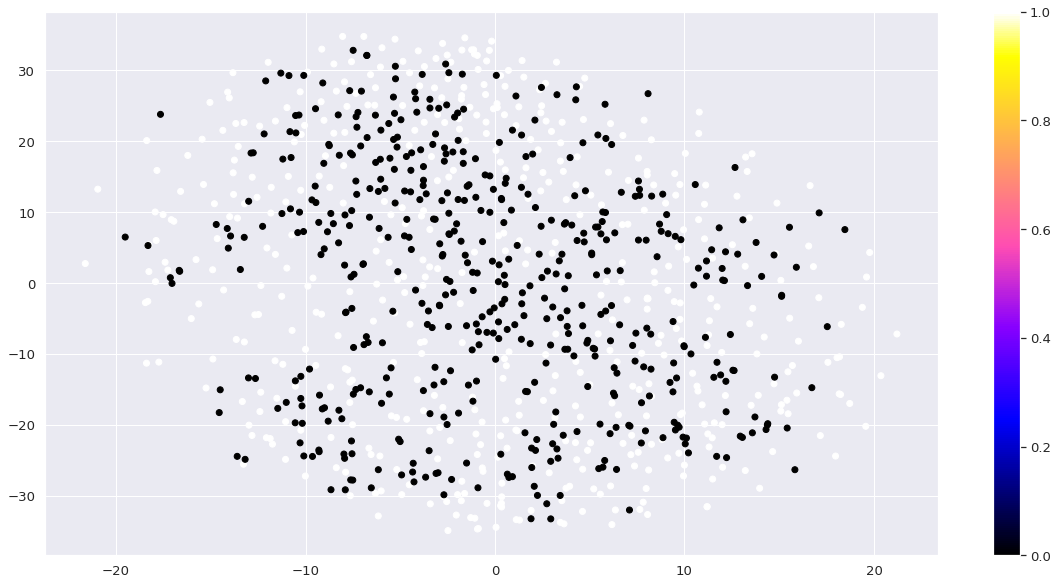

In [42]:
plt.figure(figsize=[20, 10])
graph = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_data, cmap='gnuplot2')
plt.colorbar(graph)
plt.colormaps()
plt.show()

Прокомментируйте получившийся результат:

На глаз видно, что картинки довольно неплохо перемешаны. Есть небольшие области по краяем, где преимущественно y_real, но в общим целом получилось хорошо, как мне кажется